In [1]:
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Сформируем класс для работы с данными

In [2]:
class Survivors:

    """
    Класс для работы с датафреймом.
    Параметры:
    self.df  - датафрейм
    Методы:
    unique_count(self) - метод посчета уникальных данных в столбцах
    correlation_number(self) - метод для вычисления корреляционной матрицы по числовым столбцам.
    correlation_category(self) - метод для вычисления корреляционной матрицы по категорийным столбцам
    summary_statistics(self, first_col: str, second_col: str, **kwargs) - метод вычисляет статистику по second_col, сгруппированную по first_col.
    make_graf(self, x_axis: str ='', y_axis: str ='', type_graf: str ='line') - метод построения графиков
    heatmap(self, first_col: str, second_col: str, main_col: str ) - метод построения тепловой карты
    family_surv(self) - метод поиска и отбора семей
    get_survived_families(self) - метод отбора семей где все выжили
    get_dead_families(self)- метод обора семей где все погибли
    get_some_survived_families(self): - метод обора семей, где выжил хотя бы 1 человек
    """
      
    def __init__(self, path):
        self.df = pd.read_csv(path)
    
    def unique_count(self):
        
        """
        Метод посчета уникальных данных в столбцах и вывода их списком (если они не числа)
        """
    
        for col in self.df.columns:
            unique_count: int = self.df[col].nunique()  # Количество уникальных значений для каждого столбца
            unique_values: List[Union(int|str)] = self.df[col].unique().tolist()  # Список уникальных значений для каждого столбца
            
            # Проверяем, все ли значения можно преобразовать в числа (чтобы отсеять числовые поля)
            is_numeric: bool = pd.to_numeric(self.df[col], errors='coerce').notnull().all()
            
            if is_numeric:
                print(f"Столбец '{col}': уникальных значений {unique_count} — цифровые значения")
            else:
                print(f"Столбец '{col}': уникальных значений {unique_count} — {unique_values[:5]}")

    def correlation_number(self) -> pd.DataFrame:
        
        """
        Метод для вычисления корреляционной матрицы по числовым столбцам.
        Возвращает:
        correlation_matrix - корреляционную матрицу
        """
        
        columns_list: List[Union(int|float)]  = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        correlation_matrix: pd.DataFrame = self.df[columns_list].corr()
        return correlation_matrix

    def correlation_category(self) -> pd.DataFrame:
        
        """
        Метод для вычисления корреляционной матрицы по категорийным столбцам.
        Возвращает:
        correlation_matrix - корреляционную матрицу
        """
        
        # Получаем все категориальные столбцы
        categorical_columns: List[str] = self.df.select_dtypes(include=['object', 'category']).columns.tolist()

        # Создаём копию данных, чтобы не изменять оригинальный DataFrame
        df_encoded: pd.DataFrame = self.df.copy()

        # Кодируем категориальные переменные в числовые
        label_encoder = LabelEncoder()
        for col in categorical_columns:
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

        categorical_columns.append('Survived')
        categorical_columns.append('Pclass')

        # Вычисляем корреляцию по закодированным данным
        correlation_matrix: pd.DataFrame = df_encoded[categorical_columns].corr()

        return correlation_matrix

    def summary_statistics(self, first_col: str, second_col: str, **kwargs) -> pd.DataFrame:
       
        """
        Метод для вычисления статистики по second_col, сгруппированную по first_col.
        Параметры:
        first_col - первый столбец (используется для группировки)
        second_col - второй стобец - для посчета статистики
        **kwargs - словари для фильтрации (выполняются в первую очередь)
        Возвращает:
        pd.DataFrame - статистика по сгруппированным столбцам
        """
        
        df: pd.DataFrame = self.df  # Работаем с копией DataFrame
        
        # Применяем все фильтры, если они есть
        for filter_col, filter_value in kwargs.items():
            if filter_col == 'Cabin':
                # Фильтруем по первой букве в значении столбца 'Cabin'
                df = df[df[filter_col].str[0] == filter_value]
            else:
                # Фильтруем по обычному значению
                df = df[df[filter_col] == filter_value]
        
        # Возвращаем статистику по данным
        return df[[first_col, second_col]].groupby(first_col).describe()


    def make_graf(self, x_axis: str ='', y_axis: str ='', type_graf: str ='line'):

        """
        Метод строит графики по столбцам x_axis и y_axis. 
        Параметры:
        x_axis - стобец используемый для оси X
        y_axis - стобец используемый для оси Y
        type_graf - тип графика
        """
        
        if type_graf == 'hist':
            # Гистограмма
            self.df[x_axis].plot(kind='hist', bins=20)
        elif type_graf == 'scatter':
            # Точечный график
            self.df.plot(x=x_axis, y=y_axis, kind='scatter')
        elif type_graf == 'line':
            # Линейный график
            self.df.plot(x=x_axis, y=y_axis, kind='line')
        elif type_graf == 'regression':
            # Линейная регрессия через matplotlib
            # Создаем копию DataFrame, чтобы не изменять исходные данные
            df_clean: pd.DataFrame = self.df[[x_axis, y_axis]].dropna()  # Убираем строки с пропусками
    
            x: pd.DataFrame = df_clean[x_axis]  # После dropna x и y имеют одинаковую длину
            y: pd.DataFrame = df_clean[y_axis]
    
            # Преобразуем категориальные данные в числовые (если это необходимо)
            if self.df[x_axis].dtype == 'object':  # Проверяем, если данные категориальные
                label_encoder = LabelEncoder()
                x = label_encoder.fit_transform(x)
    
                # Получаем список категорий и их количество
                categories: List = label_encoder.classes_
                category_dict = {cat: num for cat, num in zip(categories, range(len(categories)))}
                
                # Если уникальных элементов больше 5, выводим информацию как текст, а не в легенде
                if len(categories) > 5:
                    category_legend = ', '.join([f"{cat}: {num}" for cat, num in category_dict.items()])
                    print(f"Информация о кодировании {x_axis}:\n{category_legend}")
                    # Строим точечный график без легенды
                    plt.scatter(x, y, alpha=0.7)
                else:
                    # Строим точечный график и добавляем легенду с кодированием
                    category_legend = ', '.join([f"{cat}: {num}" for cat, num in category_dict.items()])
                    plt.scatter(x, y, alpha=0.7, label=f'Кодирование {x_axis}:\n{category_legend}')
    
                    # Добавляем линейную регрессию
                    m, b = np.polyfit(x, y, 1)
                    plt.plot(x, m*x + b, color='red', label=f'Линейная регрессия (y = {m:.2f}x + {b:.2f})')
    
                    # Добавляем легенду с информацией о кодировании
                    plt.legend(loc="best")
            else:
                # Строим точечный график, если данные уже числовые
                plt.scatter(x, y, alpha=0.7)
    
                # Добавляем линейную регрессию
                m, b = np.polyfit(x, y, 1)
                plt.plot(x, m*x + b, color='red', label=f'Линейная регрессия (y = {m:.2f}x + {b:.2f})')
    
                # Добавляем стандартную легенду
                plt.legend()
        elif type_graf == 'cabin_survived_with_unknown':
            # График выживаемости по каютам (группировка по первой букве каюты)
            # Создадим новый столбец, который будет содержать первую букву каюты
            self.df['Cabin_Letter'] = self.df['Cabin'].str[0].fillna('Unknown')  # Если пусто, ставим 'Unknown'
            
            # Группировка по первой букве каюты и подсчёт выживших
            cabin_groups = self.df.groupby(['Cabin_Letter', 'Survived']).size().unstack(fill_value=0)
            
            # Столбчатая диаграмма для выживаемости по каютам
            cabin_groups.plot(kind='bar', stacked=True)
            
        elif type_graf == 'cabin_survived_without_unknown':
            # График выживаемости по каютам (группировка по первой букве каюты)
            # Создадим новый столбец, который будет содержать первую букву каюты
            self.df['Cabin_Letter'] = self.df['Cabin'].str[0].fillna('Unknown')  # Если пусто, ставим 'Unknown'

            df_filtered = self.df[self.df['Cabin_Letter'] != 'Unknown']
            
            # Группировка по первой букве каюты и подсчёт выживших
            cabin_groups = df_filtered.groupby(['Cabin_Letter', 'Survived']).size().unstack(fill_value=0)
            
            # Столбчатая диаграмма для выживаемости по каютам
            cabin_groups.plot(kind='bar', stacked=True)
            
        # Добавляем заголовки и метки
        plt.title(f'Зависимость {x_axis} от {y_axis}')
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.xticks(rotation=0)
        plt.show()

    def heatmap(self, first_col: str = None, second_col: str = None, main_col: str = None, correlation: bool = False, pivot: bool = False, categorical: bool = False):
        """
        Универсальный метод построения тепловой карты.
    
        Параметры:
        - first_col: str - столбец для оси X (обязательно, если correlation=False и pivot=False)
        - second_col: str - столбец для оси Y (обязательно, если correlation=False и pivot=False)
        - main_col: str - столбец, используемый для окраски (обязательно, если correlation=False и pivot=False)
        - correlation: bool - флаг, если True, строится корреляционная матрица.
        - pivot: bool - флаг, если True, используется `pivot_table` (first_col = index, second_col = columns).
        - categorical: bool - флаг, если True, вычисляется корреляция категориальных признаков.
        
        """
        plt.figure(figsize=(10, 6))
    
        if correlation:
            if categorical:
                # Кодируем категориальные признаки числовыми значениями
                df_encoded = self.df.copy()
                for col in df_encoded.select_dtypes(include=['object']).columns:
                    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))
                heatmap_data = df_encoded.corr()
                title = "Корреляционная матрица (категориальные признаки)"
            else:
                # Обычная корреляция для числовых данных
                heatmap_data = self.df.corr(numeric_only=True)
                title = "Корреляционная матрица (числовые признаки)"
        elif pivot:
            if not first_col or not second_col or not main_col:
                raise ValueError("Для pivot-таблицы необходимо указать first_col, second_col и main_col")
            heatmap_data = self.df.pivot_table(index=first_col, columns=second_col, values=main_col, aggfunc='mean')
            title = f'Тепловая карта по {first_col} и {second_col}'
        else:
            if not first_col or not second_col or not main_col:
                raise ValueError("Необходимо указать first_col, second_col и main_col для группировки")
            heatmap_data = self.df.groupby([first_col, second_col])[main_col].mean().unstack(fill_value=0)
            title = f'Тепловая карта для {first_col} и {second_col}'
    
        sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
        plt.title(title)
        plt.xlabel(second_col if second_col else "")
        plt.ylabel(first_col if first_col else "")
    
        plt.show()

    def family_surv(self) -> pd.DataFrame:

        """
        Метод строит производит поиск и отбор семей 
        Возвращает:
        family_survival (pd.DataFrame) - датафрейм с семьями
        """
        
        # Работаем с копией, чтобы не менять оригинальный DataFrame
        df: pd.DataFrame = self.df.copy()
    
        # Извлекаем фамилию
        df['LastName'] = df['Name'].apply(lambda x: x.split(",")[0])
    
        # Создаем семейный ID на основе фамилии и билета
        df['FamilyID'] = df['LastName'] + "_" + df['Ticket'].astype(str)
    
        # Определяем детей (если Parch > 0 и возраст < 18)
        df['IsChild'] = (df['Age'] < 18) & (df['Parch'] > 0)
    
        # Определяем братьев/сестер (если SibSp > 0)
        df['HasSiblings'] = df['SibSp'] > 0
    
        # Количество мужчин и женщин в семье
        df['IsMale'] = df['Sex'] == 'male'
        df['IsFemale'] = df['Sex'] == 'female'
    
        # Группируем по семьям и считаем выживаемость
        family_survival = df.groupby('FamilyID').agg(
            count=('Survived', 'count'),  # Количество людей в семье
            sum=('Survived', 'sum'),  # Количество выживших
            mean=('Survived', 'mean'),  # Доля выживших
            avg_age=('Age', 'mean'),  # Средний возраст в семье
            num_children=('IsChild', 'sum'),  # Количество детей
            num_siblings=('HasSiblings', 'sum'),  # Количество братьев/сестер
            num_males=('IsMale', 'sum'),  # Количество мужчин в семье
            num_females=('IsFemale', 'sum')  # Количество женщин в семье
        )
    
        # Убираем семьи с 1 человеком
        family_survival = family_survival[family_survival['count'] > 1]
    
        # Сортируем по проценту выживших
        family_survival = family_survival.sort_values(by='mean', ascending=False)
    
        return family_survival

    def get_survived_families(self):
        """Возвращает семьи, где выжили все."""
        result = self.family_surv()
        return result[result['sum'] == result['count']]

    def get_dead_families(self):
        """Возвращает семьи, где все погибли."""
        result = self.family_surv()
        return result[result['sum'] == 0]

    def get_some_survived_families(self):
        """Возвращает семьи, где выжил хотя бы 1 человек"""
        result = self.family_surv()
        return result[result['sum'] > 0]

# Подгружаем данные и проверяем базовую информацию

In [3]:
# Создаем экземпляр класса
survivors = Survivors('content/train.csv')

In [4]:
# Проверим имеющиеся данные
survivors.df



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
# Выведем статистику по стобцам
survivors.df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Проверим на уникальные данные и систематизируем их
survivors.unique_count()


Столбец 'PassengerId': уникальных значений 891 — цифровые значения
Столбец 'Survived': уникальных значений 2 — цифровые значения
Столбец 'Pclass': уникальных значений 3 — цифровые значения
Столбец 'Name': уникальных значений 891 — ['Braund, Mr. Owen Harris', 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'Heikkinen, Miss. Laina', 'Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'Allen, Mr. William Henry']
Столбец 'Sex': уникальных значений 2 — ['male', 'female']
Столбец 'Age': уникальных значений 88 — [22.0, 38.0, 26.0, 35.0, nan]
Столбец 'SibSp': уникальных значений 7 — цифровые значения
Столбец 'Parch': уникальных значений 7 — цифровые значения
Столбец 'Ticket': уникальных значений 681 — ['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450']
Столбец 'Fare': уникальных значений 248 — цифровые значения
Столбец 'Cabin': уникальных значений 147 — [nan, 'C85', 'C123', 'E46', 'G6']
Столбец 'Embarked': уникальных значений 3 — ['S', 'C', 'Q', nan]


# Построим матрицы корреляции для наших столбцов

In [7]:
# Для числовых столбцов

corr_mat = survivors.correlation_number()
corr_mat

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


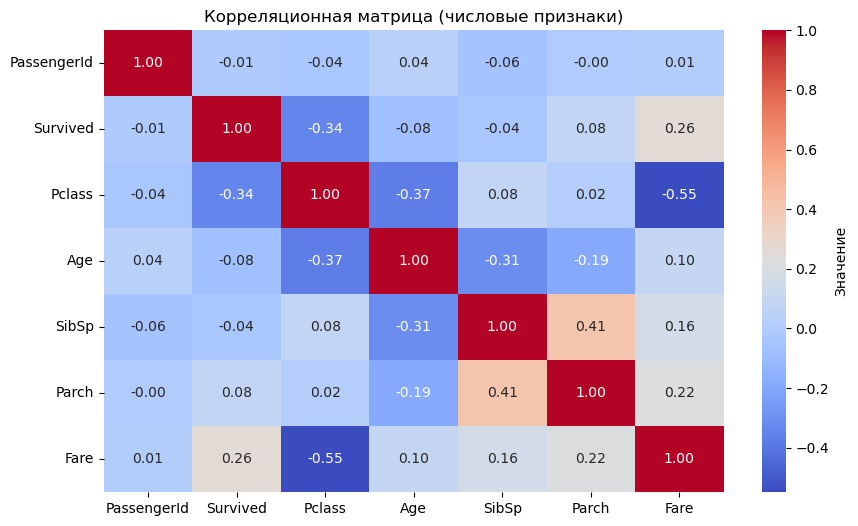

In [8]:
# Построим тепловую карту для числовых столбцов

survivors.heatmap(correlation=True)

In [9]:
# Для категорийных столбцов

corr_cat = survivors.correlation_category()
corr_cat

,Name,Sex,Ticket,Cabin,Embarked,Survived,Pclass
Name,1.000000,0.020314,0.047348,0.061959,-0.004557,-0.057343,0.052831
Sex,0.020314,1.000000,0.059372,0.096681,0.104057,-0.543351,0.131900
Ticket,0.047348,0.059372,1.000000,0.243696,-0.006041,-0.164549,0.319869
Cabin,0.061959,0.096681,0.243696,1.000000,0.193205,-0.254888,0.684121
Embarked,-0.004557,0.104057,-0.006041,0.193205,1.000000,-0.163517,0.157112
Survived,-0.057343,-0.543351,-0.164549,-0.254888,-0.163517,1.000000,-0.338481
Pclass,0.052831,0.131900,0.319869,0.684121,0.157112,-0.338481,1.000000


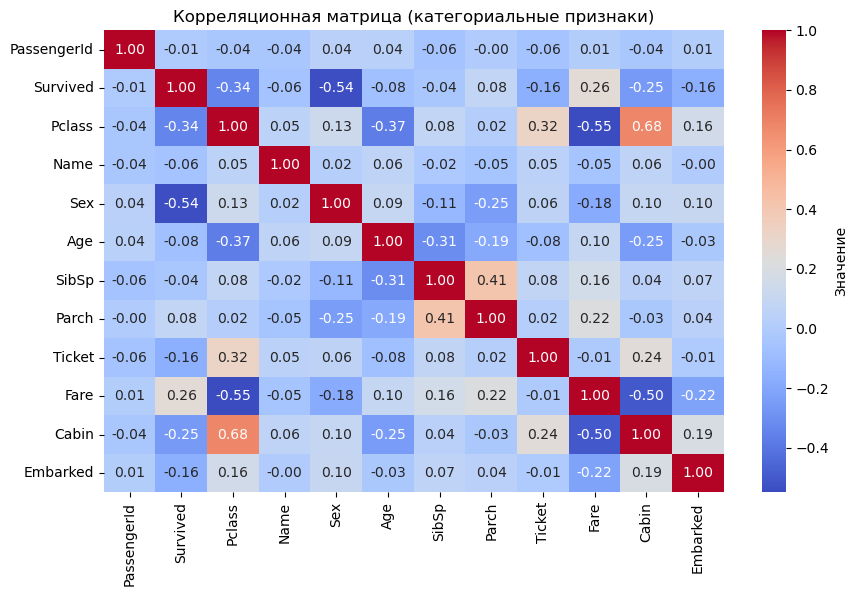

In [10]:
# Построим тепловую карту для категорийных столбцов

survivors.heatmap(correlation=True, categorical=True)


### Вывод: Наиболее сильной  корреляцией с Survived для цифровых столбцов обладают: Pclass, Fare. А для категорийных данных - Sex, Cabin

# Проверим зависимости от отдельных параметров

## Проверка зависимости Survived от Pclass

In [11]:
# Получаем статистику для нужных столбцов

survivors.summary_statistics('Survived','Pclass')

Pclass                                             
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  2.531876  0.735805  1.0  2.0  3.0  3.0  3.0
1         342.0  1.950292  0.863321  1.0  1.0  2.0  3.0  3.0

In [12]:
survivors.summary_statistics('Pclass','Survived')

Survived                                             
          count      mean       std  min  25%  50%  75%  max
Pclass                                                      
1         216.0  0.629630  0.484026  0.0  0.0  1.0  1.0  1.0
2         184.0  0.472826  0.500623  0.0  0.0  0.0  1.0  1.0
3         491.0  0.242363  0.428949  0.0  0.0  0.0  0.0  1.0

In [13]:
survivors.summary_statistics('Survived', 'Age', Survived=1)

Age                                                   
          count      mean        std   min   25%   50%   75%   max
Survived                                                          
1         290.0  28.34369  14.950952  0.42  19.0  28.0  36.0  80.0

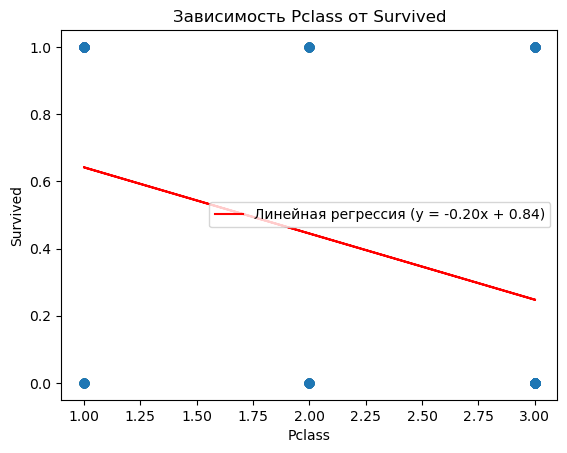

In [14]:
# Строим график зависимости с линейной регрессией
survivors.make_graf('Pclass','Survived', 'regression')

### Вывод. Исходя из графика и процентного расчета кол-ва выживших (62% для 1 класса и 24% для 3 класса) можно сделать вывод - выживаемость находится в линейной зависимости от класса пассажира. И чем ниже класс тем ниже выживаемость.

## Проверка зависимости Survived от Sex

In [15]:
# Получаем статистику для нужных столбцов
survivors.summary_statistics('Pclass','Sex')

Sex                  
       count unique   top freq
Pclass                        
1        216      2  male  122
2        184      2  male  108
3        491      2  male  347

In [16]:
survivors.summary_statistics('Pclass','Sex',Sex = 'male')

Sex                  
       count unique   top freq
Pclass                        
1        122      1  male  122
2        108      1  male  108
3        347      1  male  347

In [17]:
survivors.summary_statistics('Pclass','Sex',Sex = 'female')

Sex                    
       count unique     top freq
Pclass                          
1         94      1  female   94
2         76      1  female   76
3        144      1  female  144

In [18]:
survivors.summary_statistics('Sex','Survived')

Survived                                             
          count      mean       std  min  25%  50%  75%  max
Sex                                                         
female    314.0  0.742038  0.438211  0.0  0.0  1.0  1.0  1.0
male      577.0  0.188908  0.391775  0.0  0.0  0.0  0.0  1.0

In [19]:
survivors.summary_statistics('Survived','Age')

Age                                                    
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0

In [20]:
survivors.df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [21]:
# Получаем статистику по выжившим мужчинам
survivors.summary_statistics('Survived','Age',Survived = 1, Sex = 'male')

Age                                                    
         count       mean        std   min   25%   50%   75%   max
Survived                                                          
1         93.0  27.276022  16.504803  0.42  18.0  28.0  36.0  80.0

In [22]:
# Получаем статистику по выжившим женщинам
survivors.summary_statistics('Survived','Age',Survived = 1, Sex = 'female')

Age                                                    
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
1         197.0  28.847716  14.175073  0.75  19.0  28.0  38.0  63.0

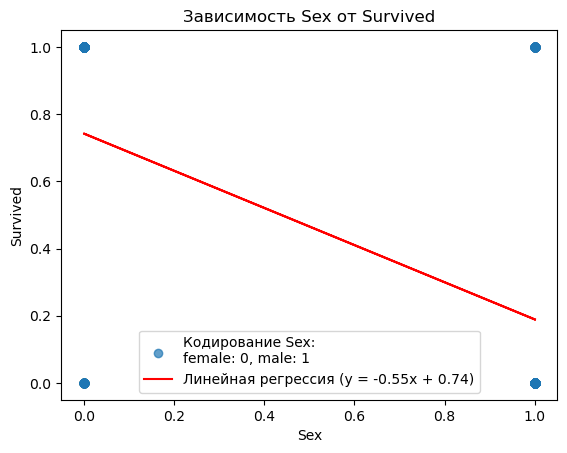

In [23]:
# Строим график зависимости с регрессивной линией
survivors.make_graf('Sex','Survived', 'regression')

### Вывод. Исходя из графика и процентного расчета кол-ва выживших (74% для женщин и 18% для мужчин) можно сделать вывод - выживаемость находится в линейной зависимости от пола пассажира. Шансов на выживание у мужчин было меньше. И ввиду того что женщин выжило в 4 раза больше чем мужчин, то можно предположить, что мужчины помогали спастись женщинам и спасательные шлюпки в первую очередь. И так же видно, что шансов выжить у людей любого пола старше 38 лет почти небыло.

## Проверка зависимости Survived от Embarked

In [24]:
# Получаем статистику по нужным столбцам
survivors.summary_statistics('Survived','Embarked')

Embarked                
            count unique top freq
Survived                         
0             549      3   S  427
1             340      3   S  217

In [25]:
survivors.summary_statistics('Embarked','Survived')

Survived                                             
            count      mean       std  min  25%  50%  75%  max
Embarked                                                      
C           168.0  0.553571  0.498608  0.0  0.0  1.0  1.0  1.0
Q            77.0  0.389610  0.490860  0.0  0.0  0.0  1.0  1.0
S           644.0  0.336957  0.473037  0.0  0.0  0.0  1.0  1.0

In [26]:
survivors.summary_statistics('Embarked','Survived',Survived = 1)

Survived                                   
            count mean  std  min  25%  50%  75%  max
Embarked                                            
C            93.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Q            30.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
S           217.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [27]:
# Получаем статистику по конкретным портам
survivors.summary_statistics('Pclass','Embarked', Embarked = 'C')

Embarked                
          count unique top freq
Pclass                         
1            85      1   C   85
2            17      1   C   17
3            66      1   C   66

In [28]:
survivors.summary_statistics('Pclass','Embarked', Embarked = 'Q')

Embarked                
          count unique top freq
Pclass                         
1             2      1   Q    2
2             3      1   Q    3
3            72      1   Q   72

In [29]:
survivors.summary_statistics('Pclass','Embarked', Embarked = 'S')

Embarked                
          count unique top freq
Pclass                         
1           127      1   S  127
2           164      1   S  164
3           353      1   S  353

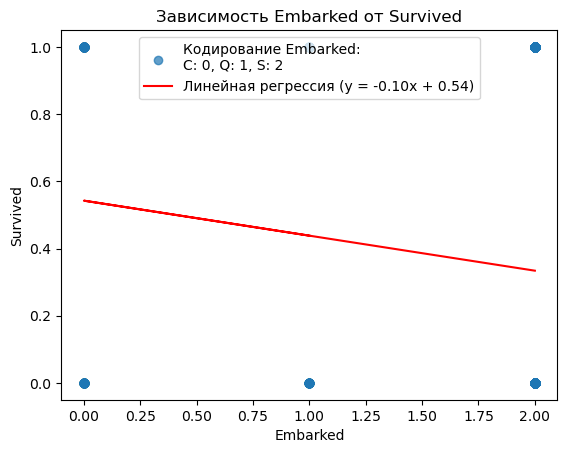

In [30]:
# Строим график зависимости с линией регресии
survivors.make_graf('Embarked','Survived', 'regression')

### Вывод: Исходя из графика можно предположить, что выживаемость для пассажиров севших в порте S выше чем в порте С. Но наши предвариательные данные по численности севших пассажиров по каждому порту показывает что в порте C пасажиров первого класса село почти столько же, сколько и пасажирова 3 класса, а в порте S пассажировов 1 класса селов 3 раза меньше. А согласно нашим предыдущим исследования выживаемость пассажиров 1 класса существенно выше. Следовательно график не учитывает кол-во "потециальнно выживающих пассажиров"

In [31]:
# Создаем новый столбец для получения обобщенных данных между Embarked, Pclass и Survived
survivors.df['survival_rate'] = survivors.df.groupby(['Embarked', 'Pclass'])['Survived'].transform('mean')

# Теперь можем использовать этот столбец для анализа
print(survivors.df[['Embarked', 'Pclass', 'survival_rate']].drop_duplicates())


    Embarked  Pclass  survival_rate
0          S       3       0.189802
1          C       1       0.694118
3          S       1       0.582677
5          Q       3       0.375000
9          C       2       0.529412
15         S       2       0.463415
19         C       3       0.378788
61       NaN       1            NaN
245        Q       1       0.500000
303        Q       2       0.666667


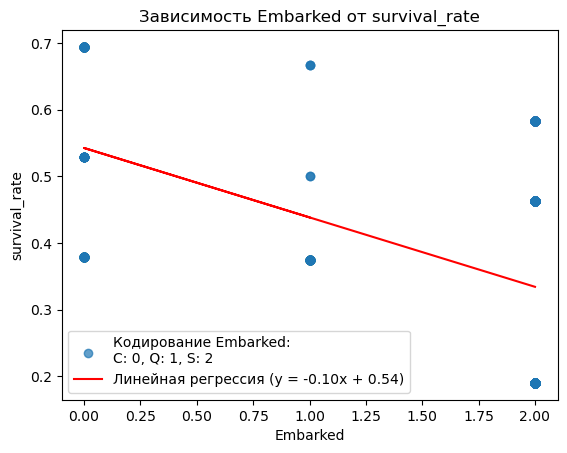

In [32]:
survivors.make_graf('Embarked','survival_rate', 'regression')

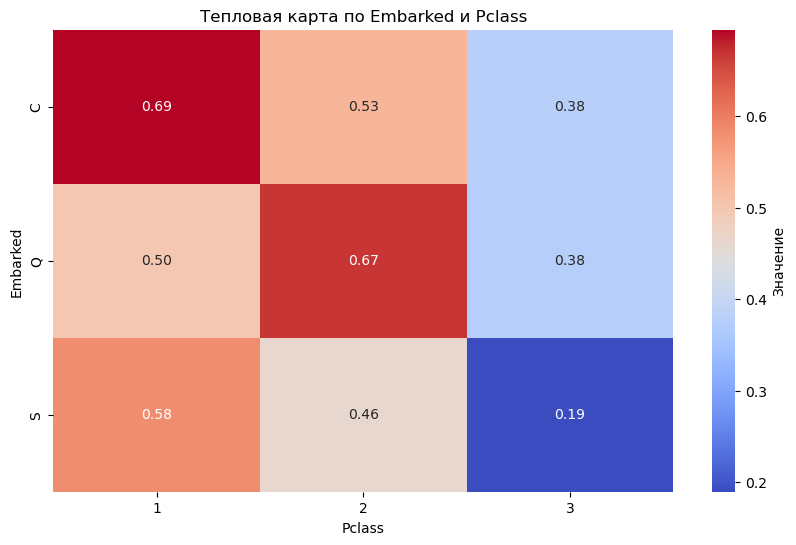

In [33]:
# Точечный график для обхединенных столбов почти не изменился поэтому попробуем построить тепловую карту

survivors.heatmap('Embarked', 'Pclass', 'survival_rate', pivot=True)

### Вывод: Тепловая карта с большего подтверждает наши выводы, кроме пассажиров 3 класса севших в порту S. Наиболее вероятная гиппотеза - отклонения вызванны нюансами расселения/ размещения пассажиров.

## Проверка зависимости Survived от Cabin

In [34]:
# Получаем статистику по нужным столбцам
survivors.summary_statistics('Survived','Cabin')

Cabin                     
         count unique      top freq
Survived                           
0           68     62       G6    2
1          136    101  B96 B98    4

In [35]:
survivors.summary_statistics('Cabin','Survived')

Survived                                       
         count mean      std  min  25%  50%  75%  max
Cabin                                                
A10        1.0  0.0      NaN  0.0  0.0  0.0  0.0  0.0
A14        1.0  0.0      NaN  0.0  0.0  0.0  0.0  0.0
A16        1.0  1.0      NaN  1.0  1.0  1.0  1.0  1.0
A19        1.0  0.0      NaN  0.0  0.0  0.0  0.0  0.0
A20        1.0  1.0      NaN  1.0  1.0  1.0  1.0  1.0
...        ...  ...      ...  ...  ...  ...  ...  ...
F33        3.0  1.0  0.00000  1.0  1.0  1.0  1.0  1.0
F38        1.0  0.0      NaN  0.0  0.0  0.0  0.0  0.0
F4         2.0  1.0  0.00000  1.0  1.0  1.0  1.0  1.0
G6         4.0  0.5  0.57735  0.0  0.0  0.5  1.0  1.0
T          1.0  0.0      NaN  0.0  0.0  0.0  0.0  0.0

[147 rows x 8 columns]

Информация о кодировании Cabin:
A10: 0, A14: 1, A16: 2, A19: 3, A20: 4, A23: 5, A24: 6, A26: 7, A31: 8, A32: 9, A34: 10, A36: 11, A5: 12, A6: 13, A7: 14, B101: 15, B102: 16, B18: 17, B19: 18, B20: 19, B22: 20, B28: 21, B3: 22, B30: 23, B35: 24, B37: 25, B38: 26, B39: 27, B4: 28, B41: 29, B42: 30, B49: 31, B5: 32, B50: 33, B51 B53 B55: 34, B57 B59 B63 B66: 35, B58 B60: 36, B69: 37, B71: 38, B73: 39, B77: 40, B78: 41, B79: 42, B80: 43, B82 B84: 44, B86: 45, B94: 46, B96 B98: 47, C101: 48, C103: 49, C104: 50, C106: 51, C110: 52, C111: 53, C118: 54, C123: 55, C124: 56, C125: 57, C126: 58, C128: 59, C148: 60, C2: 61, C22 C26: 62, C23 C25 C27: 63, C30: 64, C32: 65, C45: 66, C46: 67, C47: 68, C49: 69, C50: 70, C52: 71, C54: 72, C62 C64: 73, C65: 74, C68: 75, C7: 76, C70: 77, C78: 78, C82: 79, C83: 80, C85: 81, C86: 82, C87: 83, C90: 84, C91: 85, C92: 86, C93: 87, C95: 88, C99: 89, D: 90, D10 D12: 91, D11: 92, D15: 93, D17: 94, D19: 95, D20: 96, D21: 97, D26: 98, D28: 99, D30: 100, D33: 101, D

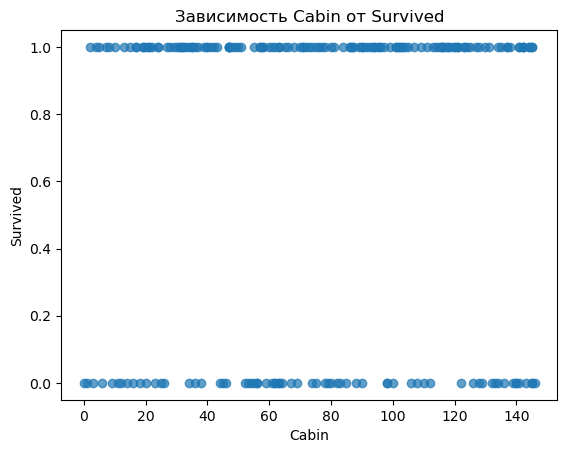

In [36]:
survivors.make_graf('Cabin','Survived', 'regression')

Построенный график не помогает про анализировать данные попробуем другие графики

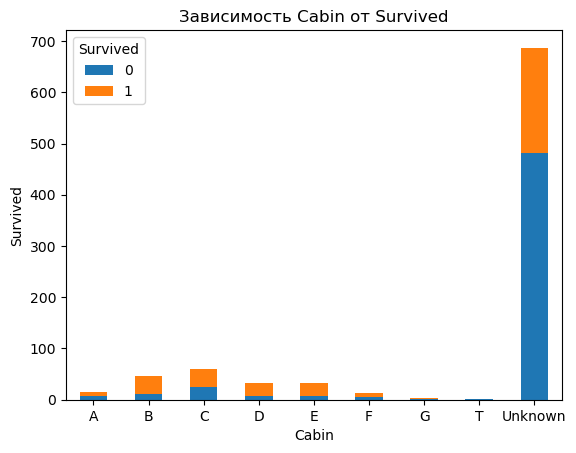

In [37]:
# Попробуем построить гистограмму
survivors.make_graf('Cabin', 'Survived', type_graf='cabin_survived_with_unknown')

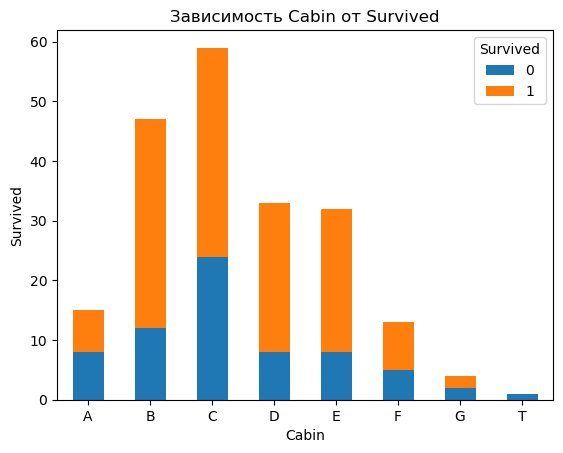

In [38]:
# Поскольку гистограмма с unknown не очнеь удобная для анализа из-за размера unknown, то построим без него
survivors.make_graf('Cabin', 'Survived', type_graf='cabin_survived_without_unknown')

In [39]:
# Получаем результат фильтрации и статистики
result =  survivors.summary_statistics('Cabin','Survived',Cabin = 'A')

# Получаем количество строк в результирующем DataFrame
num_rows = result.shape[0]
print(result)
print(f"Количество кают с выжившими в А: {num_rows}")

      Survived                                  
         count mean std  min  25%  50%  75%  max
Cabin                                           
A10        1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
A14        1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
A16        1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0
A19        1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
A20        1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0
A23        1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0
A24        1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
A26        1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0
A31        1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0
A32        1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
A34        1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0
A36        1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
A5         1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
A6         1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0
A7         1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
Количество кают с выжившими в А: 15


In [40]:
result =  survivors.summary_statistics('Survived','Cabin',Cabin = 'A')
print(result)

         Cabin                
         count unique top freq
Survived                      
0            8      8  A5    1
1            7      7  A6    1


In [41]:

# Извлекаем первую букву из столбца Cabin
survivors.df['Cabin_letter'] = survivors.df['Cabin'].str[0]

# Группируем по первой букве и считаем выживаемость
cabin_survival_stats = survivors.df.groupby('Cabin_letter')['Survived'].value_counts().unstack(fill_value=0)

# Считаем процент выживаемости
cabin_survival_stats['Survival Rate'] = cabin_survival_stats[1] / (cabin_survival_stats[0] + cabin_survival_stats[1]) * 100

# Выводим таблицу с процентами по первой букве каюты
print(cabin_survival_stats[['Survival Rate']])

Survived      Survival Rate
Cabin_letter               
A                 46.666667
B                 74.468085
C                 59.322034
D                 75.757576
E                 75.000000
F                 61.538462
G                 50.000000
T                  0.000000


In [42]:
# Попробуем добавить еще и Pclass

# Добавляем новый столбец для первой буквы каюты
survivors.df['Cabin_letter'] = survivors.df['Cabin'].str[0]

# Группируем по Pclass и Cabin_letter, считаем количество выживших и невыживших
cabin_pclass_survival = survivors.df.groupby(['Pclass', 'Cabin_letter'])['Survived'].value_counts().unstack(fill_value=0)

# Рассчитываем выживаемость для каждой группы
cabin_pclass_survival['Survival Rate'] = (cabin_pclass_survival[1] / (cabin_pclass_survival[0] + cabin_pclass_survival[1])) * 100

# Выводим результат
print(cabin_pclass_survival[['Survival Rate']])

Survived             Survival Rate
Pclass Cabin_letter               
1      A                 46.666667
       B                 74.468085
       C                 59.322034
       D                 75.862069
       E                 72.000000
       T                  0.000000
2      D                 75.000000
       E                 75.000000
       F                 87.500000
3      E                100.000000
       F                 20.000000
       G                 50.000000


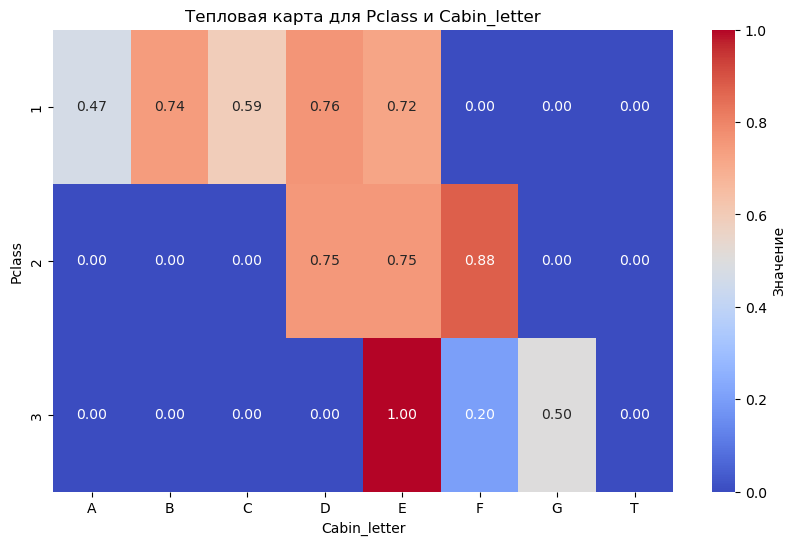

In [43]:
# Для большей наглядности построим тепловую карту

survivors.heatmap('Pclass', 'Cabin_letter','Survived')


In [44]:
# Проверим кол-во пассажиров с известными каютами для 3 класса
survivors.summary_statistics('Survived','Cabin',Cabin = 'E',Pclass =3)

Cabin                  
         count unique   top freq
Survived                        
1            3      2  E121    2

In [45]:
survivors.summary_statistics('Survived','Cabin',Cabin = 'F',Pclass =3)

Cabin                   
         count unique    top freq
Survived                         
0            4      3  F G73    2
1            1      1  F E69    1

In [46]:
survivors.summary_statistics('Survived','Cabin',Cabin = 'G',Pclass =3)

Cabin                
         count unique top freq
Survived                      
0            2      1  G6    2
1            2      1  G6    2

Итого: Из 3 класса данные по фамилиям есть всего у 8 человек

### Выводы выживаемости по классам. Тепловая карта подтверила наши предыдущие выводы о том, что более высокий класс пассажира  повышал рейтинг выживаемости. По каютам наиболшая выживаемость у кают первого класса, и у второго особенно для кают D-F, что вероятнее всего вызванно их расположением в центре корабля, т.е рядом с лестницами на палубу/выходам к шлюпкам. У третьего класса показатели очень низкие. Каюты E 3 класса это всего 3 пассажира, поэтому они не корректны для статистики. Т.к их использование приведет к "ошибке выжившего"

## Проверим выживаемость по семьям 

Для этого мы будем использовать:

Фамилии из Name (поиск "Mr.", "Mrs.", "Miss.", "Master." + фамилии)
SibSp (братья/сёстры, супруги)
Parch (родители/дети)
Ticket (один и тот же билет у пассажиров — вероятно, они ехали вместе)
Cabin (совпадение кают, если они известны)

Основная логика(подробнее см. описание функции):

Разделим Name: извлечём фамилии (по пробелу после титула).
Группировка по фамилии + билету + каюте: это создаст группы возможных семей.
Проверим выживаемость внутри каждой группы.


In [47]:
result = survivors.family_surv()
print(result)

                     count  sum  mean    avg_age  num_children  num_siblings  \
FamilyID                                                                       
Richards_29106           3    3   1.0   9.276667             2             3   
Coutts_C.A. 37671        2    2   1.0   6.000000             2             2   
Doling_231919            2    2   1.0  26.000000             0             0   
Nakid_2653               2    2   1.0  10.500000             1             1   
Frauenthal_PC 17611      2    2   1.0  50.000000             0             2   
...                    ...  ...   ...        ...           ...           ...   
Lefebre_4133             4    0   0.0        NaN             0             4   
Lobb_A/5. 3336           2    0   0.0  28.000000             0             2   
Palsson_349909           4    0   0.0  10.500000             3             3   
Panula_3101295           6    0   0.0  13.500000             5             5   
Zabour_2665              2    0   0.0  1

In [48]:
# Фильтруем семьи, где хотя бы один человек выжил (sum > 0)
survived_families = survivors.get_some_survived_families()
survived_families

,count,sum,mean,avg_age,num_children,num_siblings,num_males,num_females
FamilyID,,,,,,,,
Richards_29106,3,3,1.000000,9.276667,2,3,2,1
Coutts_C.A. 37671,2,2,1.000000,6.000000,2,2,2,0
Doling_231919,2,2,1.000000,26.000000,0,0,0,2
Nakid_2653,2,2,1.000000,10.500000,1,1,1,1
Frauenthal_PC 17611,2,2,1.000000,50.000000,0,2,1,1
...,...,...,...,...,...,...,...,...
Jacobsohn_243847,2,1,0.500000,33.000000,0,2,1,1
Abelson_P/PP 3381,2,1,0.500000,29.000000,0,2,1,1
Kantor_244367,2,1,0.500000,29.000000,0,2,1,1


In [49]:
# Фильтруем семьи, где выжили все (sum = count)
all_survived_families = result[result['sum'] == result['count']]
all_survived_families

,count,sum,mean,avg_age,num_children,num_siblings,num_males,num_females
FamilyID,,,,,,,,
Richards_29106,3,3,1.0,9.276667,2,3,2,1
Coutts_C.A. 37671,2,2,1.0,6.000000,2,2,2,0
Doling_231919,2,2,1.0,26.000000,0,0,0,2
Nakid_2653,2,2,1.0,10.500000,1,1,1,1
Frauenthal_PC 17611,2,2,1.0,50.000000,0,2,1,1
Murphy_367230,2,2,1.0,NaN,0,2,0,2
Goldenberg_17453,2,2,1.0,49.000000,0,2,1,1
Moubarek_2661,2,2,1.0,NaN,0,2,2,0
Hamalainen_250649,2,2,1.0,12.335000,1,1,1,1


In [50]:
# выводим статистику данным 
all_survived_families.describe()

,count,sum,mean,avg_age,num_children,num_siblings,num_males,num_females
count,33.000000,33.000000,33.0,29.000000,33.000000,33.000000,33.000000,33.000000
mean,2.181818,2.181818,1.0,24.398908,0.636364,1.666667,0.787879,1.393939
std,0.527645,0.527645,0.0,14.204623,0.859440,0.889757,0.649883,0.747470
min,2.000000,2.000000,1.0,2.500000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.0,12.335000,0.000000,1.000000,0.000000,1.000000
50%,2.000000,2.000000,1.0,24.000000,0.000000,2.000000,1.000000,1.000000
75%,2.000000,2.000000,1.0,36.000000,1.000000,2.000000,1.000000,2.000000
max,4.000000,4.000000,1.0,50.000000,3.000000,4.000000,2.000000,4.000000


In [52]:
# Фильтруем семьи, где все погибли (sum = 0)
dead_families = survivors.get_dead_families()
dead_families

,count,sum,mean,avg_age,num_children,num_siblings,num_males,num_females
FamilyID,,,,,,,,
Skoog_347088,6,0,0.0,18.333333,4,6,3,3
Turpin_11668,2,0,0.0,28.000000,0,2,1,1
Van Impe_345773,3,0,0.0,25.333333,1,2,1,2
Vander Planke_345764,2,0,0.0,17.000000,0,2,1,1
White_35281,2,0,0.0,37.500000,0,0,2,0
Sage_CA. 2343,7,0,0.0,NaN,0,7,4,3
Strom_347054,2,0,0.0,15.500000,1,1,0,2
Johnson_LINE,2,0,0.0,34.000000,0,0,2,0
Rosblom_370129,2,0,0.0,29.500000,0,1,1,1


In [53]:
# выводим статистику данным 
dead_families.describe()

,count,sum,mean,avg_age,num_children,num_siblings,num_males,num_females
count,26.000000,26.0,26.0,23.000000,26.000000,26.000000,26.000000,26.000000
mean,3.269231,0.0,0.0,23.574534,1.192308,2.769231,1.615385,1.653846
std,1.778937,0.0,0.0,10.155273,1.855138,2.045633,1.387859,1.164210
min,2.000000,0.0,0.0,9.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.0,0.0,15.583333,0.000000,2.000000,1.000000,1.000000
50%,2.000000,0.0,0.0,23.500000,0.000000,2.000000,1.000000,1.000000
75%,4.000000,0.0,0.0,30.250000,1.750000,4.000000,2.000000,2.000000
max,7.000000,0.0,0.0,49.000000,5.000000,7.000000,5.000000,5.000000


Предвариательные выводы:
- Размер семьи и выживаемость:
Средний размер семьи среди полностью выживших — 2.18 человека, среди погибших — 3.27 человека.
Маленькие семьи выживали чаще. Возможно, им было проще найти место в шлюпках.
Максимальный размер семьи среди выживших — 4 человека, среди погибших — 7 человек.
Большие семьи выживали реже, вероятно, из-за сложностей с эвакуацией.
- Возраст и выживаемость
Средний возраст среди выживших — 24.4 года, среди погибших — 23.6 года.
Разница небольшая, но в среднем выжившие семьи были чуть старше.
Минимальный возраст среди выживших — 2.5 года, среди погибших — 9 лет.
Дети в семьях выживали чаще, возможно, из-за политики «сначала дети и женщины».
- Количество детей
В выживших семьях в среднем 0.64 ребенка, в погибших — 1.19 ребенка.
Семьи с большим числом детей выживали реже. Возможно, родителей с несколькими детьми было сложнее эвакуировать.
- Пол и выживаемость
Среднее число женщин в выживших семьях — 1.39, в погибших — 1.65.
Среднее число мужчин в выживших семьях — 0.79, в погибших — 1.62.
Семьи с большим количеством мужчин погибали чаще, что подтверждает вывод «сначала женщины и дети».
В выживших семьях было меньше мужчин и чуть меньше женщин, что может говорить о том, что в первую очередь спасали женщин и детей, но не всех.
- Братья/сестры и выживаемость
В выживших семьях 1.67 брата/сестры, в погибших — 2.77 брата/сестры.
Чем больше братьев и сестер, тем ниже шанс выживания. Возможно, родители жертвовали собой ради детей, но не всех удавалось спасти.

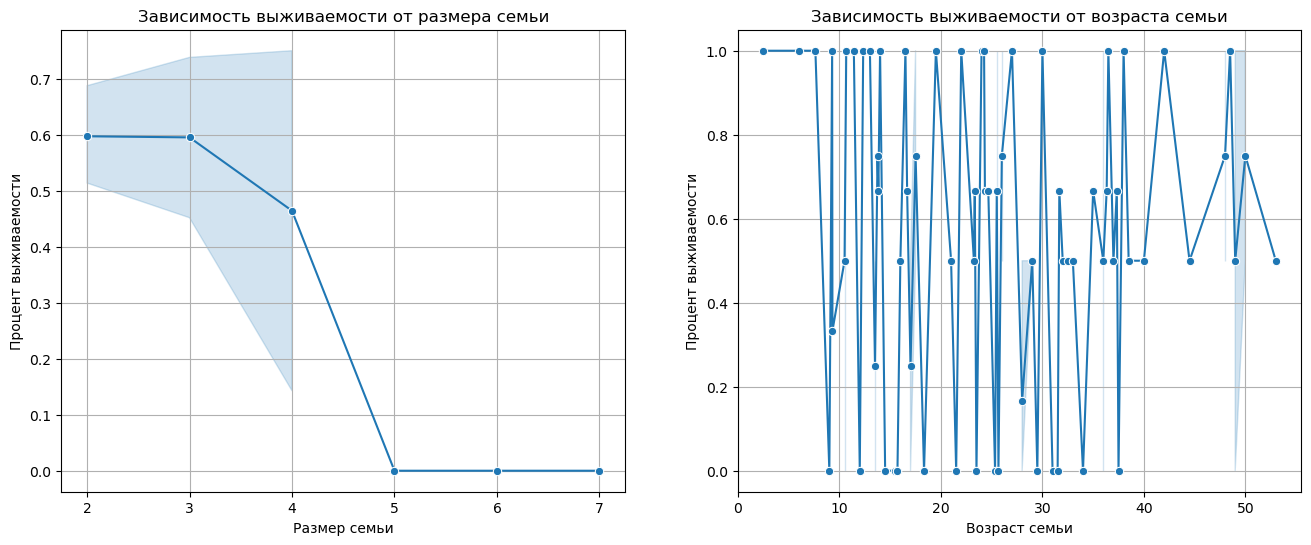

In [54]:
# Добавляем размер семьи в таблицу FamilySize = count (количество членов семьи)
result['FamilySize'] = result['count']  # размер семьи
result['Age_average'] = result['avg_age']  # средний возраст

# Построим линейный график зависимости выживаемости от размера семьи

# Настройка размера фигуры и подграфиков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 строка, 2 столбца графиков

# Построение графика зависимости выживаемости от размера семьи
sns.lineplot(x='FamilySize', y='mean', data=result, marker='o', ax=axes[0])
axes[0].set_title('Зависимость выживаемости от размера семьи')  # Используем set_title
axes[0].set_xlabel('Размер семьи')  # Используем set_xlabel
axes[0].set_ylabel('Процент выживаемости')  # Используем set_ylabel
axes[0].grid(True)

# Построение графика зависимости выживаемости от среднего возраста семьи
sns.lineplot(x='Age_average', y='mean', data=result, marker='o', ax=axes[1])
axes[1].set_title('Зависимость выживаемости от возраста семьи')  # Используем set_title
axes[1].set_xlabel('Возраст семьи')  # Используем set_xlabel
axes[1].set_ylabel('Процент выживаемости')  # Используем set_ylabel
axes[1].grid(True)

# Показать графики
plt.show()

### Выводы: Размер семьи и выживаемость
График только подтвердил наши выводы и что
- Маленькие семьи (до 4 человек) выживали чаще, чем большие. 
- Семьи с детьми до 2.5 лет выживали, а с детьми старше 9 лет — уже нет.
- Чем больше мужчин в семье, тем ниже шанс выживания.
- Чем больше братьев/сестер, тем ниже шанс выживания.
- Женщины и маленькие дети чаще выживали.Так же как и старики в большинстве случаев

## Проверим зависимость косвенных параметров. 

## Зависимость Pclass и Fare

In [55]:
# выводим статистику по нужным столбцам
survivors.summary_statistics('Pclass','Fare')

Fare                                                              
        count       mean        std  min       25%      50%   75%       max
Pclass                                                                     
1       216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292
2       184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000
3       491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500

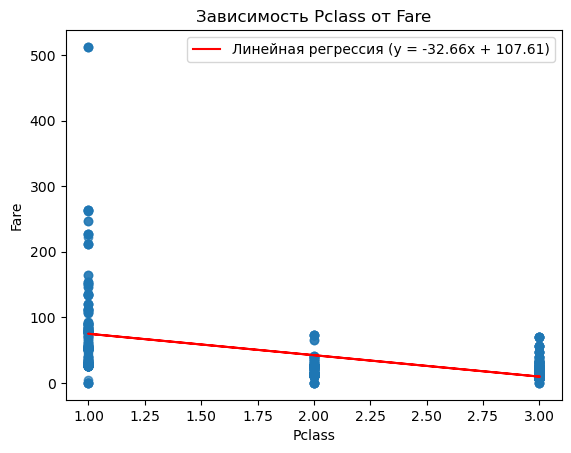

In [56]:
# Строим график зависимости с регрессией
survivors.make_graf('Pclass','Fare', 'regression')

### Выводы: Стоимомть проезда очевидно напрямую зависит от класса каюты. Чем выше класс тем дороже. Колебания тарифа в пределах класса вызванно видимо доп удобствами 

## Зависимость Pclass и Age

In [57]:
# выводим статистику по нужным столбцам
survivors.summary_statistics('Pclass','Age')

Age                                                    
        count       mean        std   min   25%   50%   75%   max
Pclass                                                           
1       186.0  38.233441  14.802856  0.92  27.0  37.0  49.0  80.0
2       173.0  29.877630  14.001077  0.67  23.0  29.0  36.0  70.0
3       355.0  25.140620  12.495398  0.42  18.0  24.0  32.0  74.0

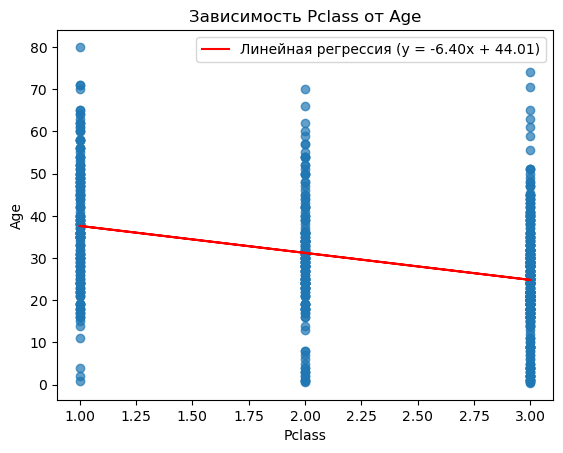

In [58]:
# Строим график зависимости с регрессией
survivors.make_graf('Pclass','Age', 'regression')

Средний возраст пассажиров 1 класса 38,23, 2 класса - 29,8, 3 - 25,14,  и даже 75% процентиль подтверждает туже зависимость: 1-49, 2- 36, 3 - 32. Т.е 1 класс могли позволить себе более возрастные пассажиры

### Выводы: 1 класс могли позволить себе более возрастные пассажиры (т.е 1 класс большая часть 27-49 лет, 2 класс- 23-36 лет, 3 класс 18-32 лет)